In [1]:
%load_ext autoreload
%autoreload 2

from eval import EvalArguments, get_artifact_path
from train import HyphenDetection

## Load Model

In [2]:
args = EvalArguments()
model: HyphenDetection = HyphenDetection.load_from_checkpoint(
        str(get_artifact_path(args.artifact_name, args.artifact_tag) / "best.ckpt"),
        dataset=args.dataset,
    )
#model.to("cuda")
model.eval()

2021-02-05 10:19:57.984 | INFO     | common.hyphen_dataset:__init__:30 - Reading annotations...
1564612it [00:04, 386870.71it/s]
2021-02-05 10:20:03.075 | INFO     | common.hyphen_dataset:__init__:43 - Found the following class counts [1548711   15901]
2021-02-05 10:20:03.084 | INFO     | common.hyphen_dataset:__init__:65 - Loaded dataset
2021-02-05 10:20:03.085 | INFO     | common.hyphen_dataset:__init__:30 - Reading annotations...
321895it [00:00, 390921.70it/s]
2021-02-05 10:20:04.124 | INFO     | common.hyphen_dataset:__init__:43 - Found the following class counts [317581   4314]
2021-02-05 10:20:04.126 | INFO     | common.hyphen_dataset:__init__:65 - Loaded dataset


orm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (conv_dw): Conv2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), groups=192, bias=False)
          (bn2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(192, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 192, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pwl): Conv2d(192, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): InvertedResidual(
          (conv_pw): Conv2d(48, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

## Load Data

In [3]:
from pathlib import Path
images = list(Path(args.eval_dir).glob("**/*Laser.bmp"))
centers = model.val_dataset.get_centers_for_image(model.val_dataset._image_paths[0])

In [28]:
from captum.attr import IntegratedGradients
from captum.attr import visualization
import numpy as np
from PIL import Image
from common.segmentation import PatchDataset
import os
from torch.utils.data import DataLoader
import torch

image_path = images[0]
image = Image.open(image_path).convert("RGB").resize((780, 660))
image = np.array(image)

patches = PatchDataset(image, centers, args.patch_size)
patches = DataLoader(
    patches, batch_size=1, num_workers=os.cpu_count() or 1
)

ig = IntegratedGradients(model)

attrs = []
for batch in patches:
    attributions = ig.attribute(batch.to(model.device), target=1)
    attrs.append(attributions)
    break


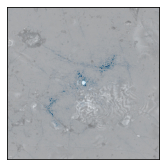

In [60]:
import matplotlib.pyplot as plt

patch = (batch[0, 1:] + batch[0, 0]).clamp(0, 1).transpose(2, 0).numpy()
attr = attrs[0][0, 1:].transpose(2, 0).numpy()
fig = plt.figure()
grid = plt.GridSpec(1, 2)
attr_ax = fig.add_subplot(grid[0, 0])
_ = visualization.visualize_image_attr(attr, original_image=patch, method='blended_heat_map', plt_fig_axis=(fig, attr_ax))
img_ax = fig.add_subplot(grid[0, 1])
img_ax.imshow(patch)
img_ax.axis("off")
fig.tight_layout()
fig.savefig("./attribution.png")